This notebook implements the scRNA-seq pre-processing and RNA velocity computation

In [1]:
import numpy as np
import pandas as pd

import scanpy as scp
import scvelo as scv

import seaborn as sns
from matplotlib import pyplot as plt

import palantir

from scipy import sparse

import os

import warnings

%load_ext jupyter_black

import warnings

warnings.simplefilter("ignore", category=UserWarning)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
full_data_path = "adata_clustered_full_extra_patient.h5ad"

adata_process = scp.read(full_data_path)

# remove patient LHCC48
print(adata_process.shape)
adata_process = adata_process[
    adata_process.obs.index[adata_process.obs.Patient != "LHCC48"]
]
print(adata_process.shape)


# select cd8 cells only
is_cd8 = [
    True if "CD8" in adata_process.obs.loc[idx, "Cluster label"] else False
    for idx in adata_process.obs.index.values
]
adata_process = adata_process[is_cd8]
print(adata_process.shape)

(27527, 36601)
(21477, 36601)
(11766, 36601)


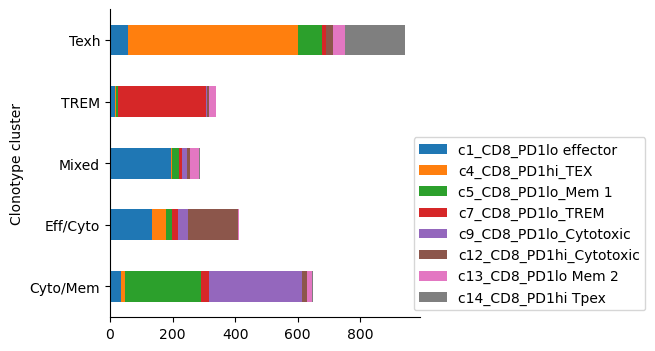

In [3]:
# For applying velocity on only Clonotype clusters (Requires running the TCR_data and TCR_clustering notebooks first)

adata_process.obs["Clonotype cluster"] = (
    pd.read_csv("clonotype_clusters_kmeans_5_clusters_good.csv")
    .set_index("new_index")["Clonotype cluster"]
    .astype("category")
)

count_df_ = (
    adata_process[adata_process.obs["Clonotype cluster"] != "-1"]
    .obs.value_counts(["Cluster label", "Clonotype cluster"])
    .reset_index()
    .pivot(index="Clonotype cluster", columns="Cluster label", values="count")
).fillna(0)
count_df_.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.75, 0), loc="lower right")
plt.show()

#adata_process = adata_process[adata_process.obs["Clonotype cluster"] == "Eff/Cyto"]

In [23]:
#Apply pre-processing 
scv.pp.filter_genes(adata_process, min_shared_counts=10)

scp.pp.highly_variable_genes(
    adata_process,
    batch_key="Sample",
    flavor="seurat_v3",
    n_top_genes=3000,
    subset=False,
)

#save raw counts
adata_process.raw = adata_process.copy()

scv.pp.normalize_per_cell(adata_process)
scp.pp.log1p(adata_process)

adata_process.shape

Filtered out 29492 genes that are detected 10 counts (shared).
(11766, 7109)
Normalized count data: X, spliced, unspliced.


(11766, 7109)

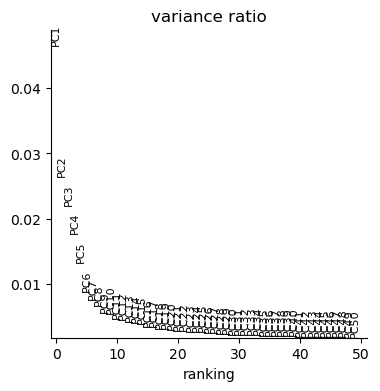

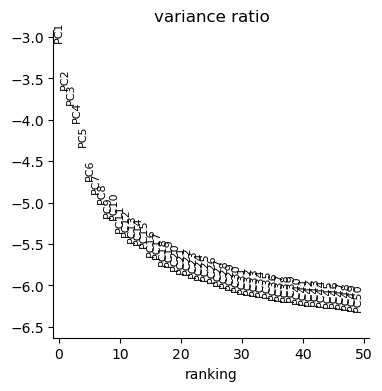

In [13]:
scp.tl.pca(adata_process, use_highly_variable=True)
scp.pl.pca_variance_ratio(adata_process, n_pcs=50, log=False)
scp.pl.pca_variance_ratio(adata_process, n_pcs=50, log=True)

2025-09-29 06:13:25,003 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-09-29 06:13:25,933 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-09-29 06:13:25,966 - harmonypy - INFO - Iteration 1 of 20
INFO:harmonypy:Iteration 1 of 20
2025-09-29 06:13:28,139 - harmonypy - INFO - Iteration 2 of 20
INFO:harmonypy:Iteration 2 of 20
2025-09-29 06:13:30,338 - harmonypy - INFO - Iteration 3 of 20
INFO:harmonypy:Iteration 3 of 20
2025-09-29 06:13:32,493 - harmonypy - INFO - Iteration 4 of 20
INFO:harmonypy:Iteration 4 of 20
2025-09-29 06:13:33,963 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


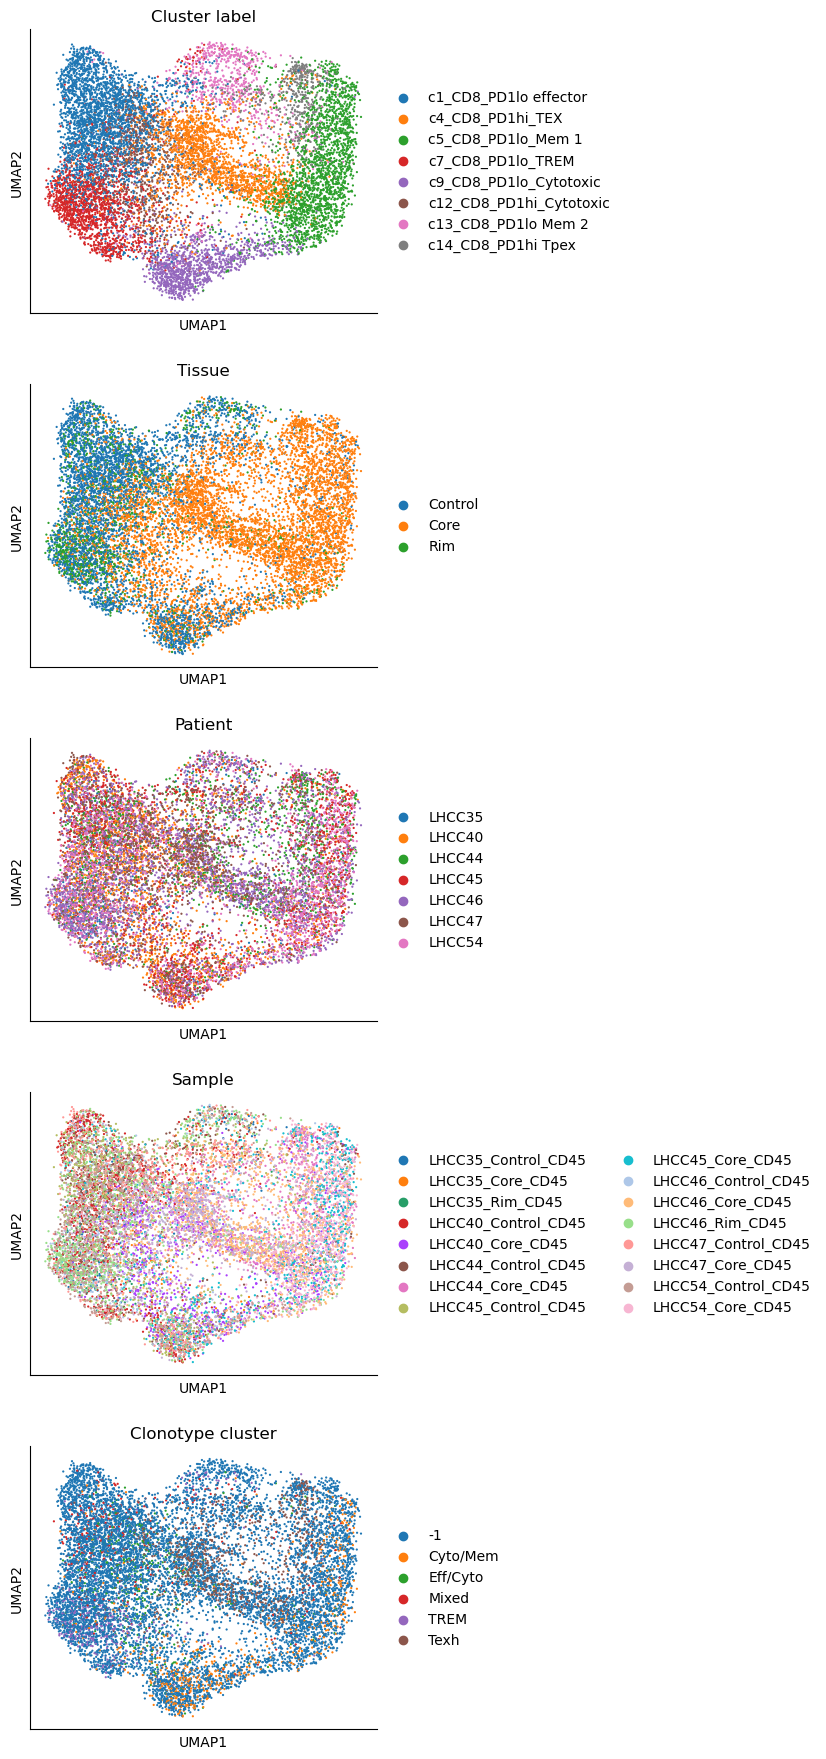

In [24]:
# compute PCA, apply batch correction ,and then finally compute UMAP projection
scp.pp.pca(adata_process, use_highly_variable=True)

# Batch correction with harmony
idx = adata_process.obs.sort_values("Patient").index
adata_process = adata_process[idx,]
scp.external.pp.harmony_integrate(adata_process, key="Patient", max_iter_harmony=20)

scp.pp.neighbors(adata_process, n_neighbors=30, use_rep="X_pca_harmony")

scp.tl.umap(adata_process, random_state=0, min_dist=0.5, spread=1)
scp.pl.umap(
    adata_process,
    color=[
        "Cluster label",
        "Tissue",
        "Patient",
        "Sample",
        "Clonotype cluster",
    ],
    cmap="YlGnBu",
    legend_loc="right margin",
    ncols=1,
)

In [31]:
# Compute velocity
# Smooth over k neighbors
scv.pp.moments(adata_process, use_rep="X_pca_harmony")

# Compute gene dynamics
scv.tl.recover_dynamics(adata_process, n_jobs=-1)

# Estimate velocity
scv.tl.velocity(adata_process, mode="dynamical")

# Post velocity analysis
scv.tl.velocity_graph(adata_process, mode_neighbors="distances", n_jobs=-1)
scv.tl.terminal_states(adata_process)
scv.tl.latent_time(adata_process)

scv.tl.velocity_confidence(adata_process)

computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 28/28 cores)


  0%|          | 0/314 [00:00<?, ?gene/s]

    finished (0:00:53) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 28/28 cores)


  0%|          | 0/11766 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 9 regions of root cells and 1 region of end points .
    finished (0:00:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:04) --> added 
    'latent_time', shared time (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


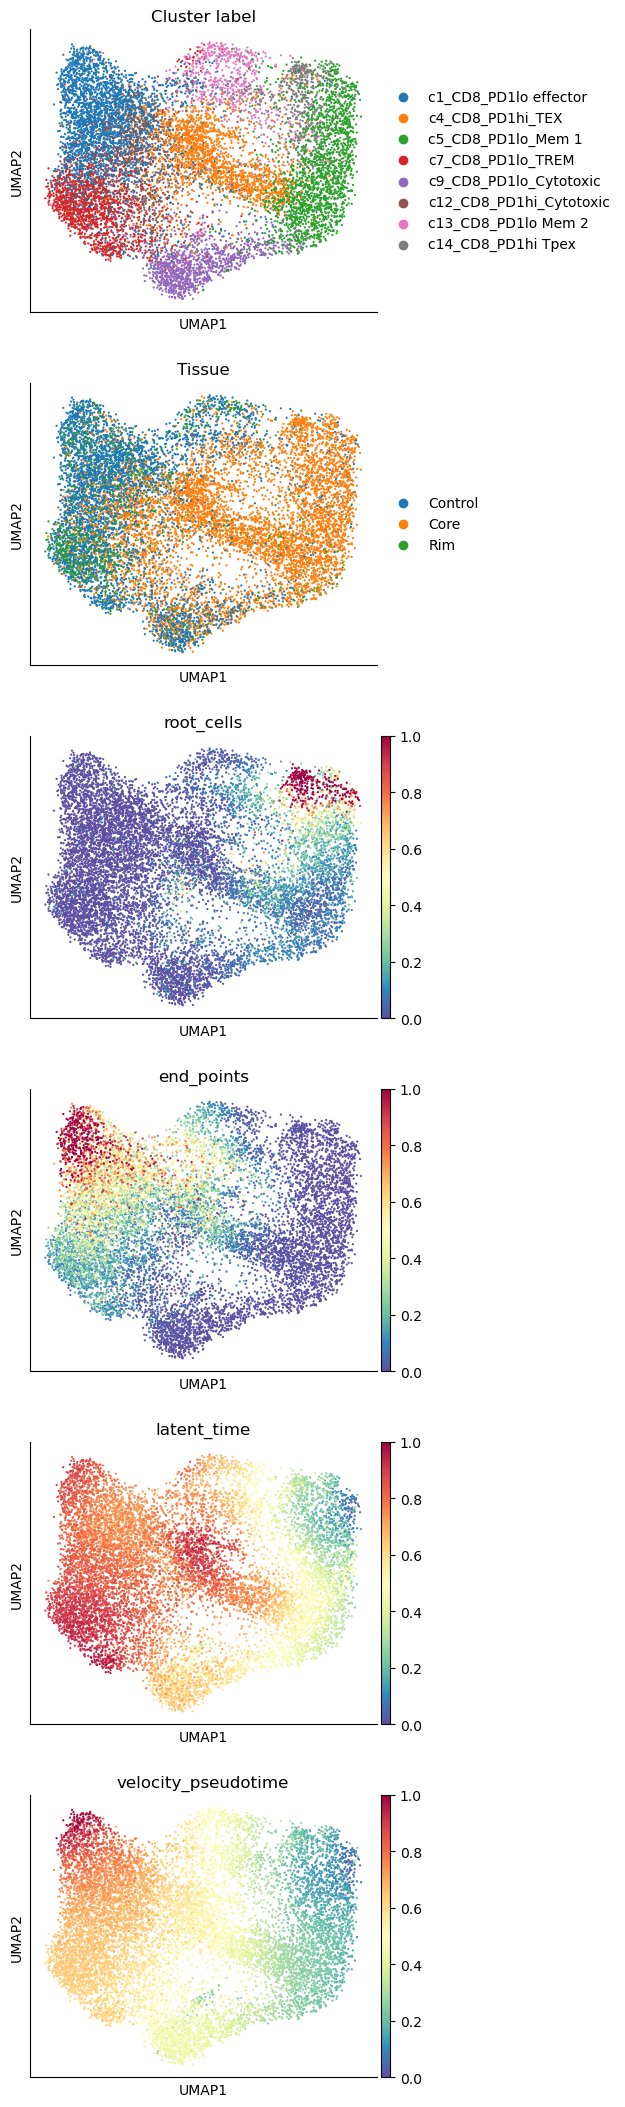

/home/ubuntu/miniconda3/envs/barbu_env_cr/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/ubuntu/miniconda3/envs/barbu_env_cr/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/ubuntu/miniconda3/envs/barbu_env_cr/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/ubuntu/miniconda3/envs/barbu_env_c

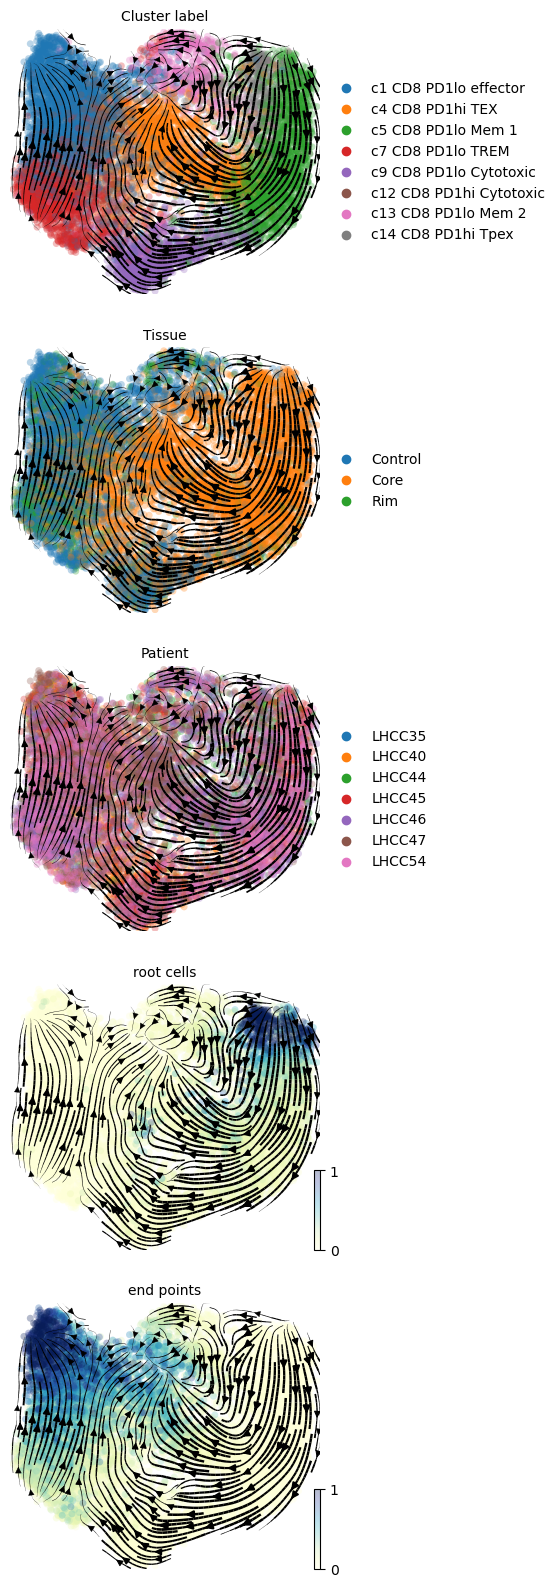

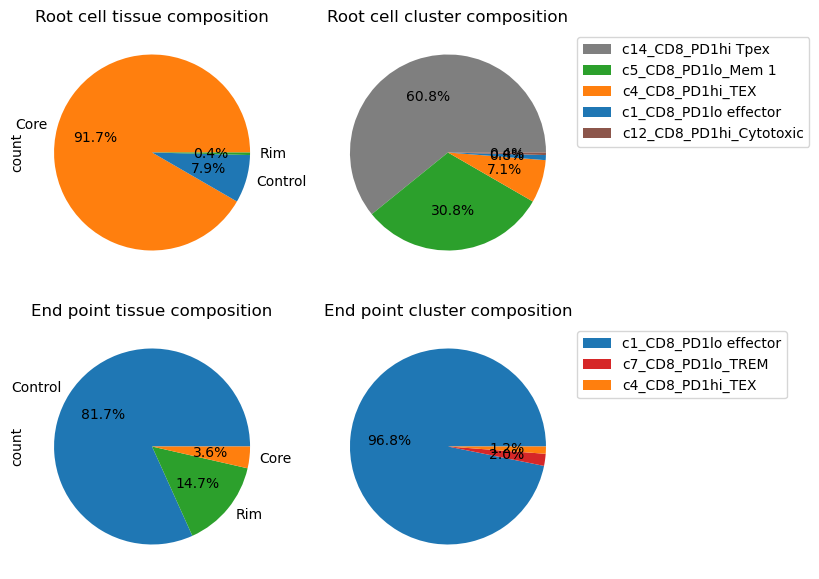

In [32]:
# Visualise velocity
scv.tl.velocity_embedding(adata_process)

scp.pl.umap(
    adata_process,
    color=[
        "Cluster label",
        "Tissue",
        "root_cells",
        "end_points",
        "latent_time",
        "velocity_pseudotime",
    ],
    ncols=1,
    legend_loc="right margin",
)

scv.pl.velocity_embedding_stream(
    adata_process,
    ncols=1,
    color=[
        "Cluster label",
        "Tissue",
        "Patient",
        "root_cells",
        "end_points",
    ],
    color_map="YlGnBu",
    legend_loc="right margin",
    size=100,
)

from utils import plot_root_end_point_composition

plot_root_end_point_composition(adata_process)

In [35]:
# Save results
adata_process.write("adata_CD8_velocity_all.h5ad")